# Prediction avec un seul modele

## Section 1: Preparation des donnees

### Import des packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle 

In [2]:
from warnings import simplefilter
simplefilter('ignore')

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [24]:
from forecast import forecast as lf

In [25]:
# models necessary to define the forecasting models 
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import (
    StatsForecastAutoARIMA,
    StatsForecastAutoETS, 
    StatsForecastAutoTheta
)
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.fbprophet import Prophet

### Lire les donnees

In [26]:
data_folder = '../data'

In [27]:
filename = os.path.join(data_folder, 'script_001_bdd.csv')
data = pd.read_csv(filename, parse_dates=['date'], index_col=['date']).dropna().sort_index()

In [28]:
data.head(2)

,BMC,jo_RIM,Pre_ramadan,Ramadan,Pre_Afitr,Post_AFitr,Pre_Akebir,Post_Akebir,Pre_ferie,Post_ferie,Pre_elec,Post_elec,Achat_or,Last_Day,First_Day
date,,,,,,,,,,,,,,,
2018-04-02,17.355653,1,0,0,0,0,0,0,0,0,0,0,0.0,0,0
2018-04-03,17.442521,1,0,0,0,0,0,0,0,0,0,0,0.0,0,0


### List des variables exogenes

In [29]:
exog_l = list(set(data.columns) - set(['BMC']))
exog_l

['Post_elec',
 'First_Day',
 'Achat_or',
 'Post_Akebir',
 'Post_AFitr',
 'Pre_ferie',
 'jo_RIM',
 'Pre_elec',
 'Ramadan',
 'Pre_Akebir',
 'Post_ferie',
 'Pre_ramadan',
 'Pre_Afitr',
 'Last_Day']

## Section 2: Specification du probleme

### Differenciation simple et saisoniere

In [30]:
bmc_transformations = {
 'Serie': data.BMC,
 'Premiere difference':  data.BMC.diff().dropna(), 
 'Deuxieme difference':  data.BMC.diff().diff().dropna(), 
 'Difference Saisoniere 5':  data.BMC.diff(5).dropna(), 
}

### Etude ACF/PACF

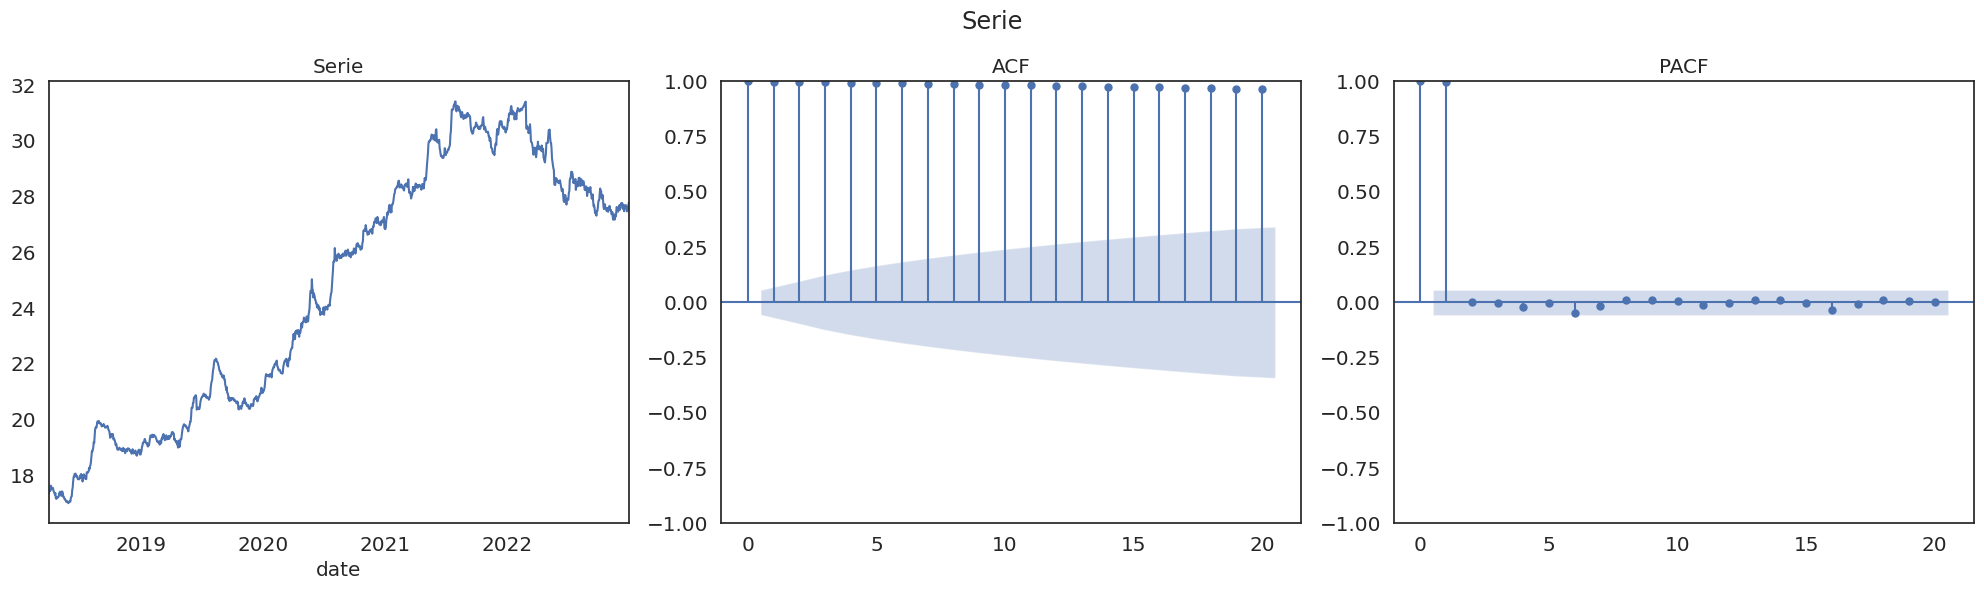

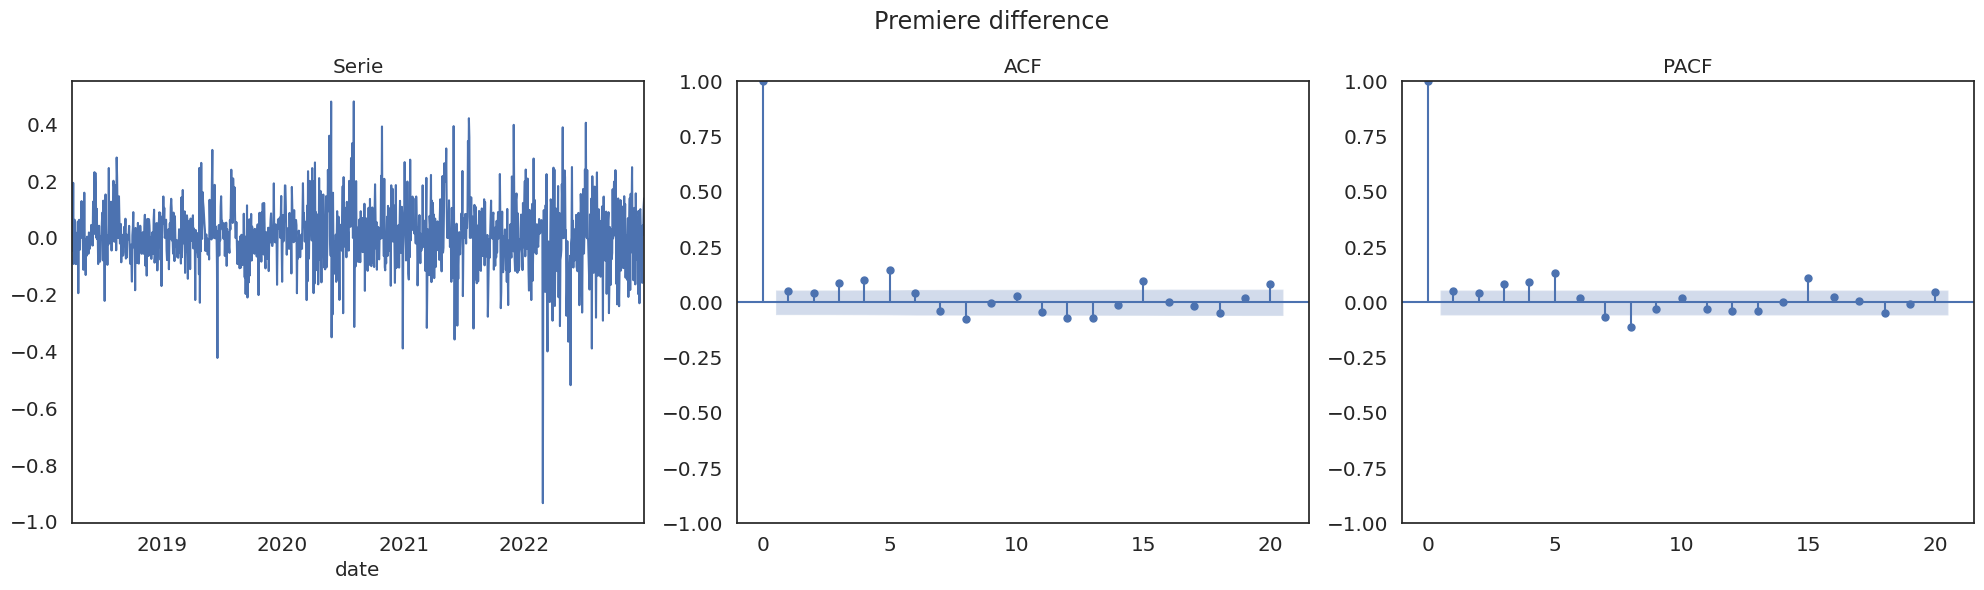

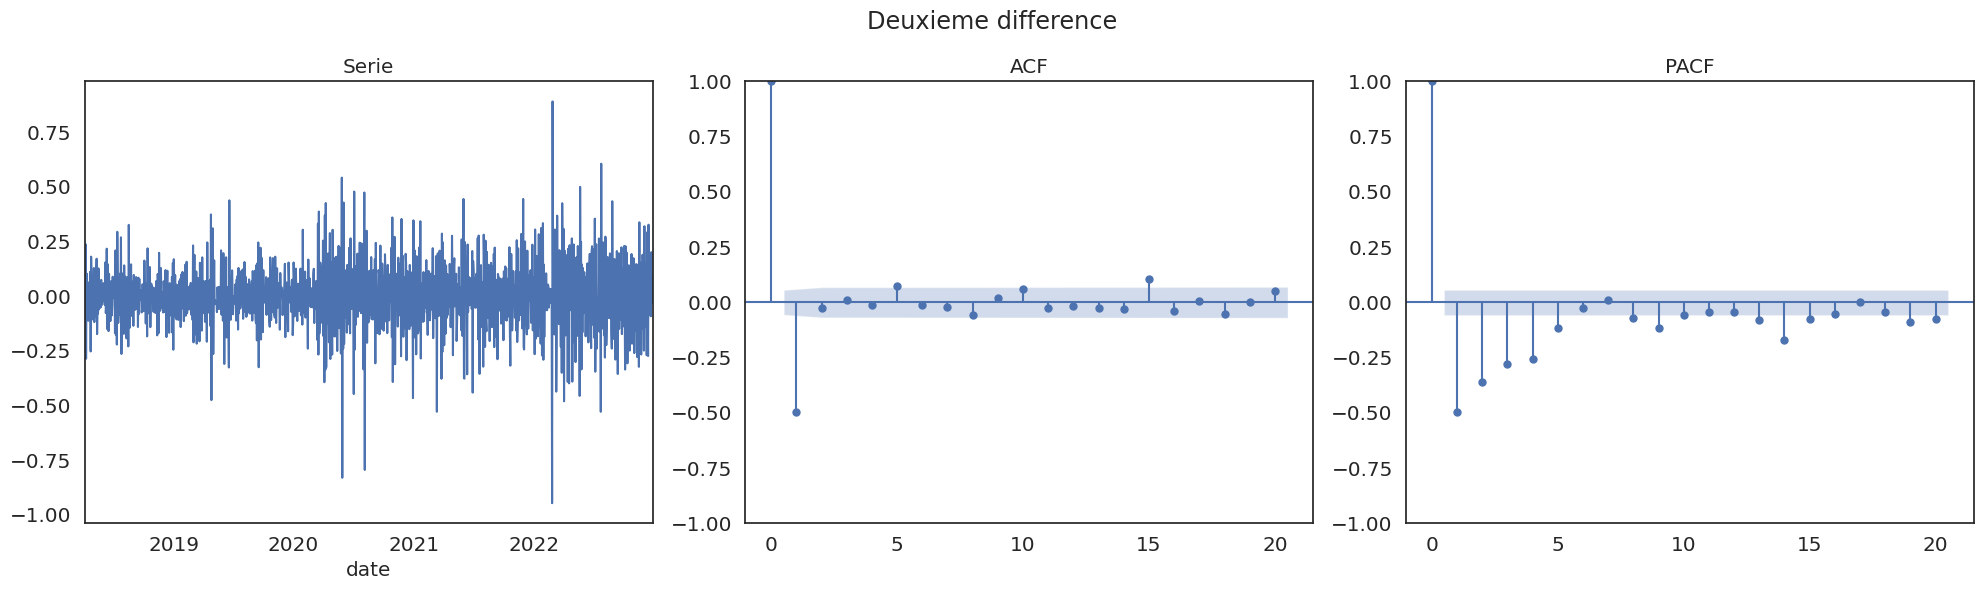

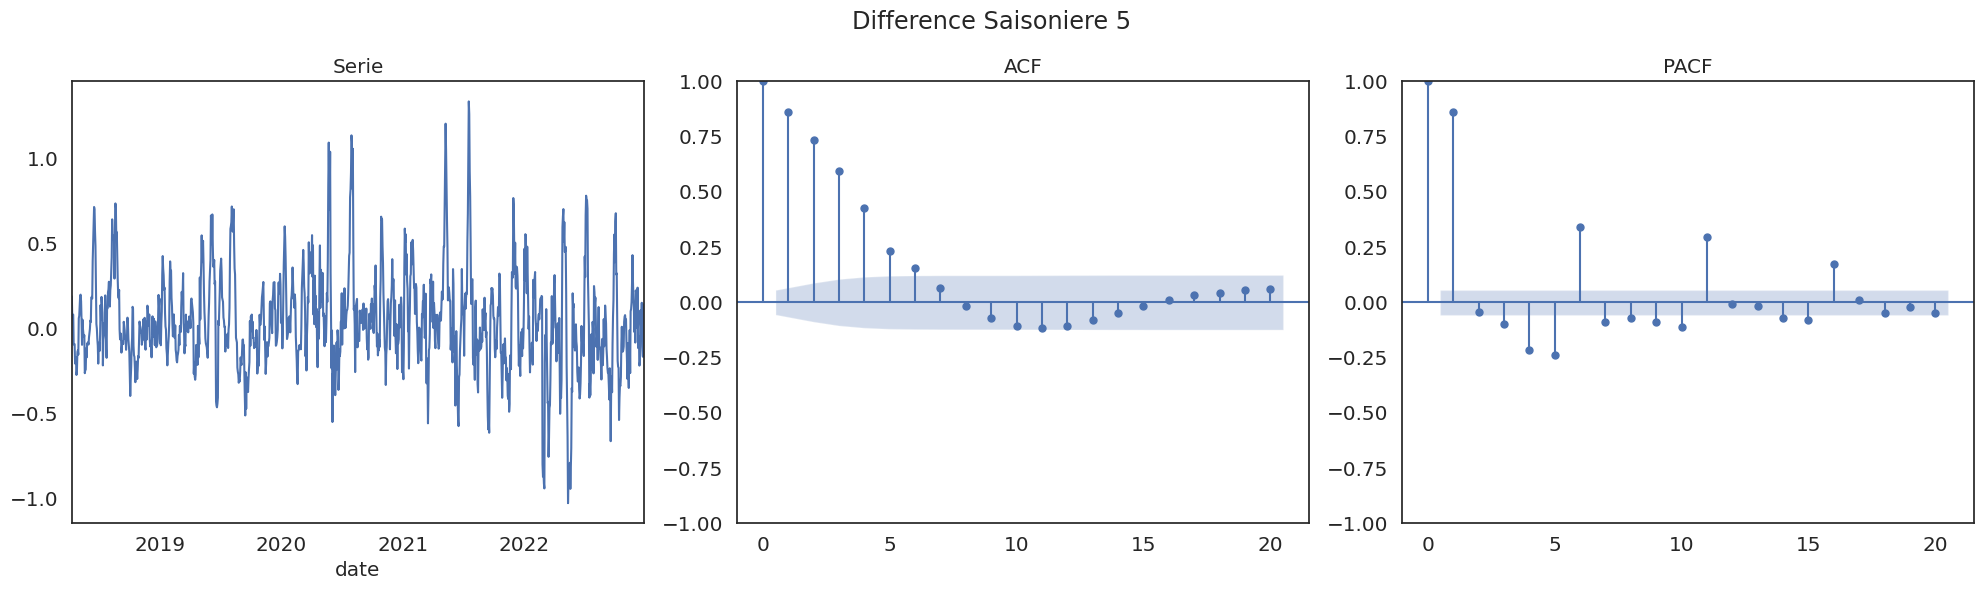

In [31]:
nrows = len(bmc_transformations)
for i, (title, serie) in enumerate(bmc_transformations.items()):    
    f, axes =plt.subplots(1,3, figsize=(20, 6))
    serie.plot(ax = axes[0], title = 'Serie')
    plot_acf(serie, lags=20, alpha=0.05, title='ACF', ax=axes[1])
    plot_pacf(serie, lags=20, alpha=0.05, title='PACF', ax=axes[2])    
    plt.suptitle(title, fontsize='x-large')
    plt.tight_layout()
    plt.show()

## Section 3: Definir le modele

In [32]:
model = StatsForecastAutoARIMA(n_jobs = 4, trend=True, seasonal=True, max_p= 10, max_q=10)

In [41]:
LF = lf.Forecast(data = data,
                          depvar_str='BMC',      
                          exog_l= exog_l,
                          forecaster_name = 'AutoARIMA',
                          forecaster= model,
                          fh = 5,
                          pct_initial_window = 0.5,
                          step_length = 25, 
                          freq = 'B')

## Section 4: In-sample vs Out-Of-smaple

### Procedure d'evaluation

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Echantillon enrtrainement vs Echantillon de Test'}, ylabel='Billets et Monnaie en Circulation\n(Milliards de MRU)'>)

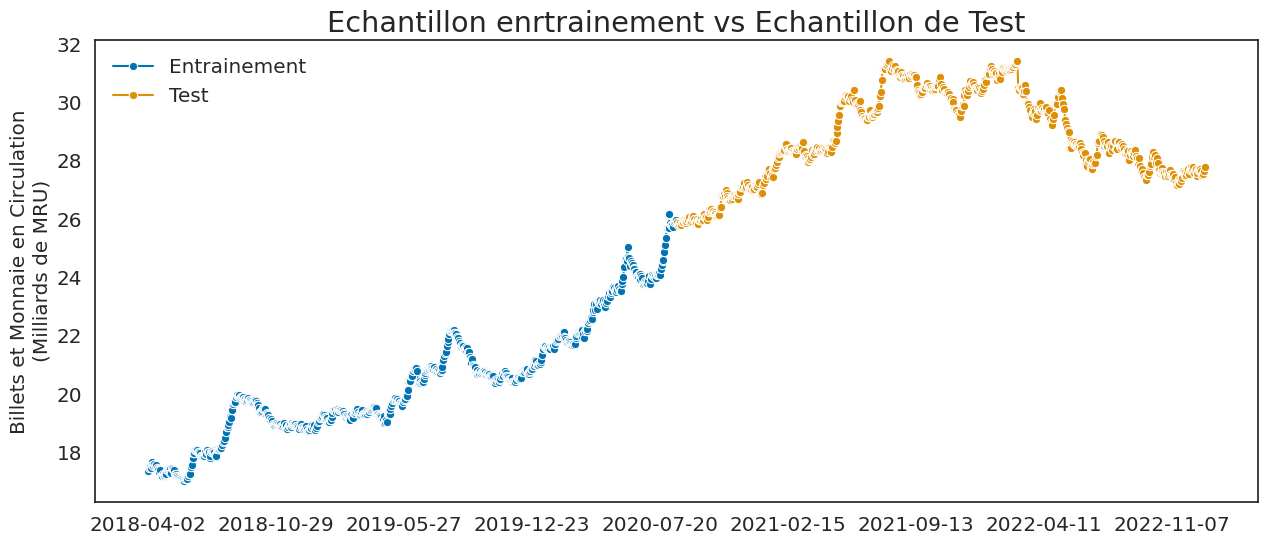

In [42]:
LF.plot.plot_train_test(
    labels = ['Entrainement', 'Test'],
    ylabel='Billets et Monnaie en Circulation\n(Milliards de MRU)', 
    title='Echantillon enrtrainement vs Echantillon de Test', )

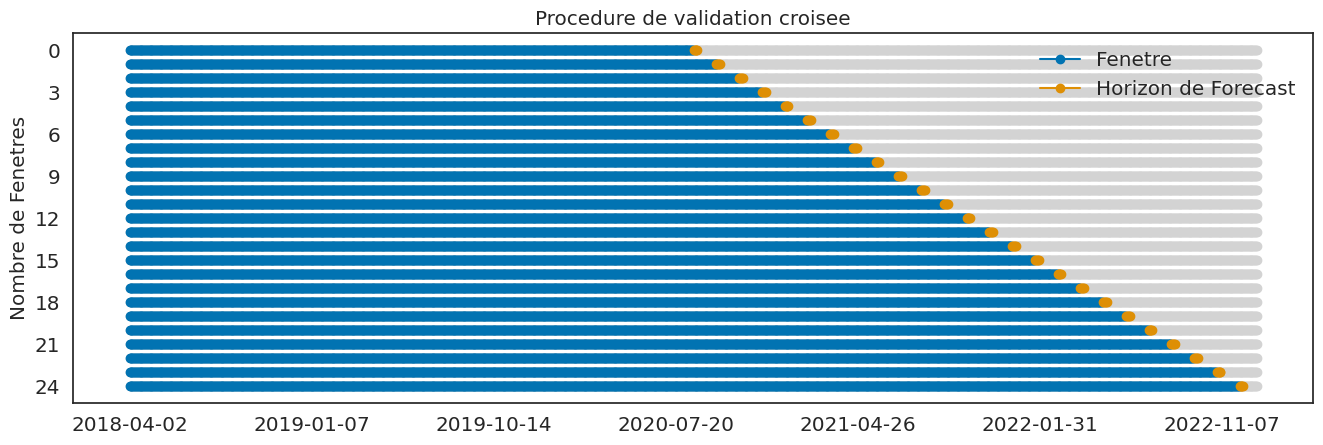

In [43]:
LF.plot.plot_cv_procedure(
    labels = ['Fenetre', 'Horizon de Forecast'],
    xlabel='', 
    ylabel = 'Nombre de Fenetres',
    title='Procedure de validation croisee'
)

### Ajustement

In [44]:
lf_fit= LF.fit(on='train')

### Evaluation En Echantillon (In-sample)

In [45]:
pred = lf_fit.insample_predictions(nsample =200)
display(pred.head())

200it [00:02, 78.31it/s]


,index,y_pred,y_true,Abs_diff,horizon,cutoff
0,2018-04-04,17.434188,17.487638,0.053451,1,2018-04-03
1,2018-04-05,17.491310,17.442940,0.048370,2,2018-04-03
2,2018-04-06,17.467667,17.636495,0.168827,3,2018-04-03
3,2018-04-09,17.622861,17.544536,0.078325,4,2018-04-03
4,2018-04-10,17.581109,17.505403,0.075706,5,2018-04-03


In [46]:
insample_perf_summary = lf_fit.insample_perf()

In [47]:
insample_perf_summary['horizon']

,RMSE,MAPE
horizon,,
1,0.083350,0.003087
2,0.099865,0.003674
3,0.091784,0.003237
4,0.103816,0.003553
5,0.093698,0.003281


In [48]:
display(insample_perf_summary['cutoff'].head())
display(insample_perf_summary['horizon'].head())

,RMSE,MAPE
cutoff,,
2018-04-03,0.095463,0.004838
2018-04-06,0.055033,0.002799
2018-04-09,0.057018,0.002882
2018-04-11,0.049483,0.002493
2018-04-17,0.083964,0.003919


,RMSE,MAPE
horizon,,
1,0.083350,0.003087
2,0.099865,0.003674
3,0.091784,0.003237
4,0.103816,0.003553
5,0.093698,0.003281


In [49]:
lf_fit.plot.plot_insample_performance?

Signature:
lf_fit.plot.plot_insample_performance(
    metric: str = 'RMSE',
    title: str = 'Insample Performance',
)
Docstring:
Plot the insample performance metrics.

Parameters:
    metric : str, optional
        The performance metric to plot. Default is 'RMSE'.
    title : str, optional
        The title of the plot. Default is 'Insample Performance'.
File:      ~/Documents/Projects/forecast/forecast/forecast.py
Type:      method

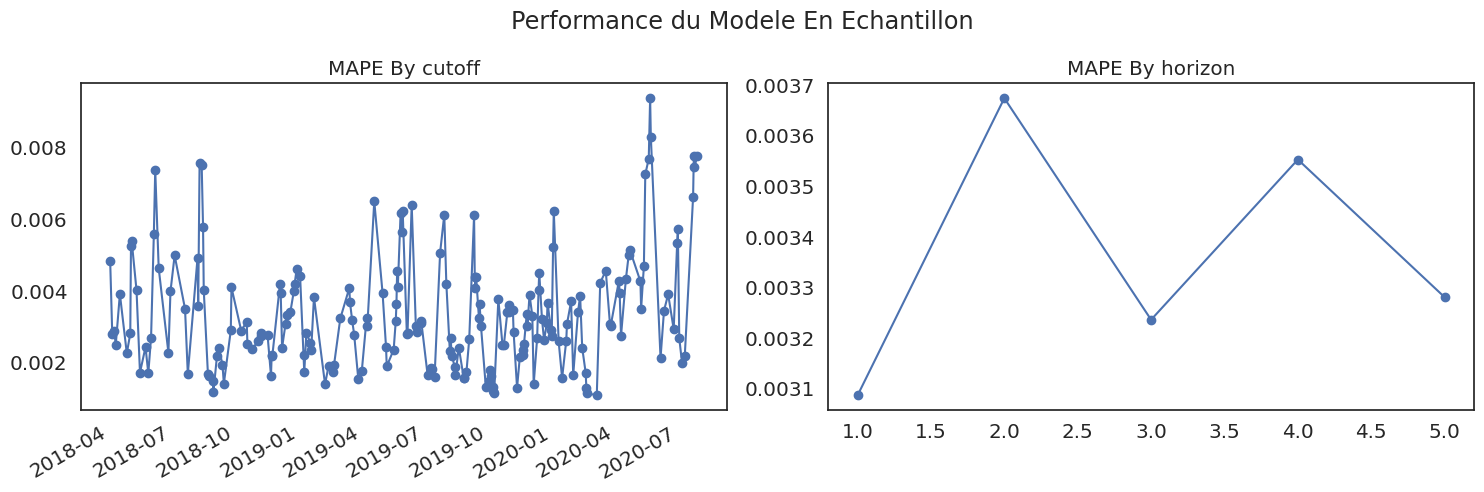

In [50]:
lf_fit.plot.plot_insample_performance(metric='MAPE', title = 'Performance du Modele En Echantillon')

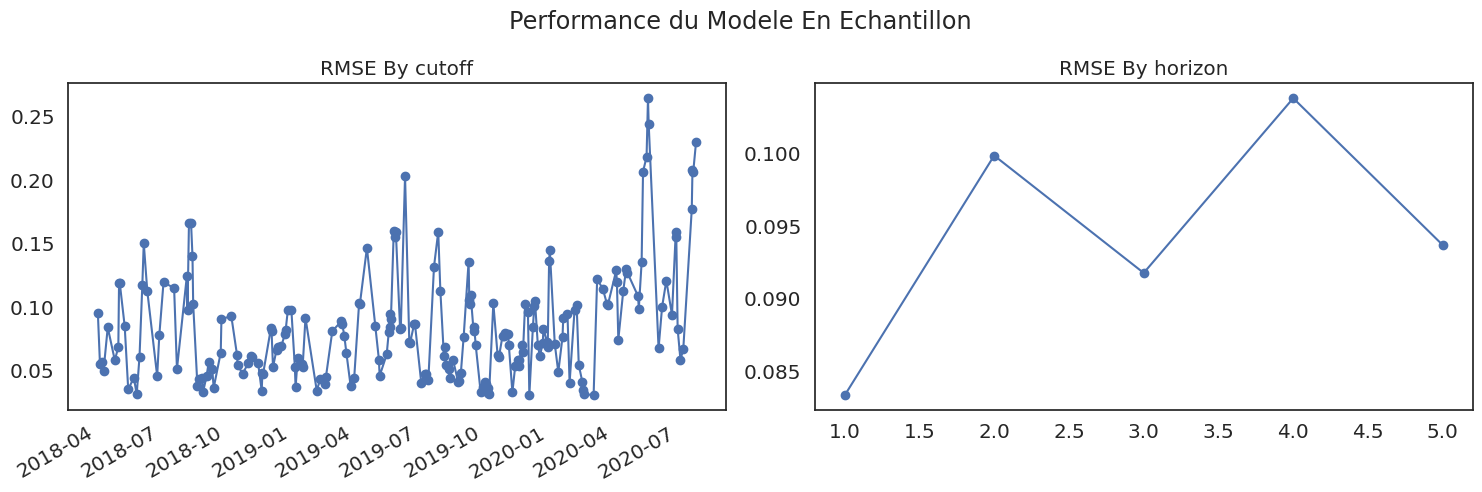

In [51]:
lf_fit.plot.plot_insample_performance(metric='RMSE', title = 'Performance du Modele En Echantillon')

### Evaluation Hors Echantillon (Out-Of-sample)

In [52]:
lf_eval= LF.evaluate()


Start forecaster AutoARIMA evalution....
 Depending on the forecaster this step may take couple of minutes. Please don't kill the kernel
Evaluation time: 1.864 minutes


In [53]:
lf_eval.summary_results?

Signature: lf_eval.summary_results() -> pandas.core.frame.DataFrame
Docstring:
Generate a summary of out-of-sample forecast results.

Returns:
    pd.DataFrame
        A DataFrame containing various summary statistics of the out-of-sample forecasts.
File:      ~/Documents/Projects/forecast/forecast/forecast.py
Type:      method

In [54]:
lf_eval.summary_results()

,Number of Folds,Avg Fit time (s),Avg_pred_time (s),Smallest training window,Largest training window,First cutoff,Last cutoff,Avg MAPE,Avg RMSE
0,25,4.388937,0.060134,620,1220,2020-08-14,2022-12-02,0.007105,0.22614


In [55]:
lf_eval.summary_horizon()

,RMSE,MAPE
horizon,,
1,0.230714,0.004678
2,0.267344,0.006225
3,0.300290,0.006961
4,0.339597,0.008411
5,0.372552,0.009251


In [56]:
lf_eval.plot.plot_oos_score?

Signature:
lf_eval.plot.plot_oos_score(
    score: str = 'RMSE',
    xlabel: str = None,
    ylabel: str = None,
    title: str = 'Out of Sample Performance - Average on All Horizons',
    ax: Optional[matplotlib.axes._axes.Axes] = None,
    figsize: Tuple[float, float] = (15, 6),
)
Docstring:
Plot out-of-sample performance metric historically.

Parameters:
    score : str, optional
        The performance metric to plot. Default is 'RMSE'.
    xlabel : str, optional
        Label for the x-axis.
    ylabel : str, optional
        Label for the y-axis.
    title : str, optional
        The title of the plot. Default is 'Out of Sample Performance - Average on All Horizons'.
    ax : plt.Axes, optional
        The Axes object for the plot.
    figsize : Tuple[float, float], optional
        The figure size. Default is (15, 6).
File:      ~/Documents/Projects/forecast/forecast/forecast.py
Type:      method

<Axes: title={'center': 'Performance historique hors echantillion'}, ylabel='MAPE Moyen sur tous les horizons'>

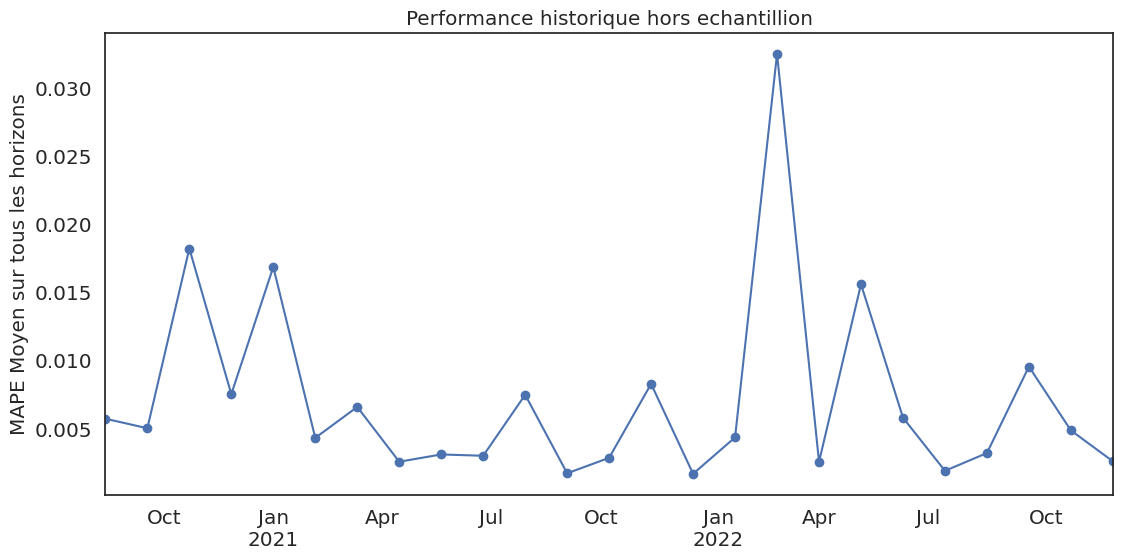

In [57]:
lf_eval.plot.plot_oos_score(score = 'MAPE', 
                            ylabel = 'MAPE Moyen sur tous les horizons',
                            title ='Performance historique hors echantillion', 
                            figsize = (13,6)
                           )

<Axes: title={'center': 'Performance historique hors echantillion'}, xlabel='Horizon', ylabel='MAPE moyen par horizon'>

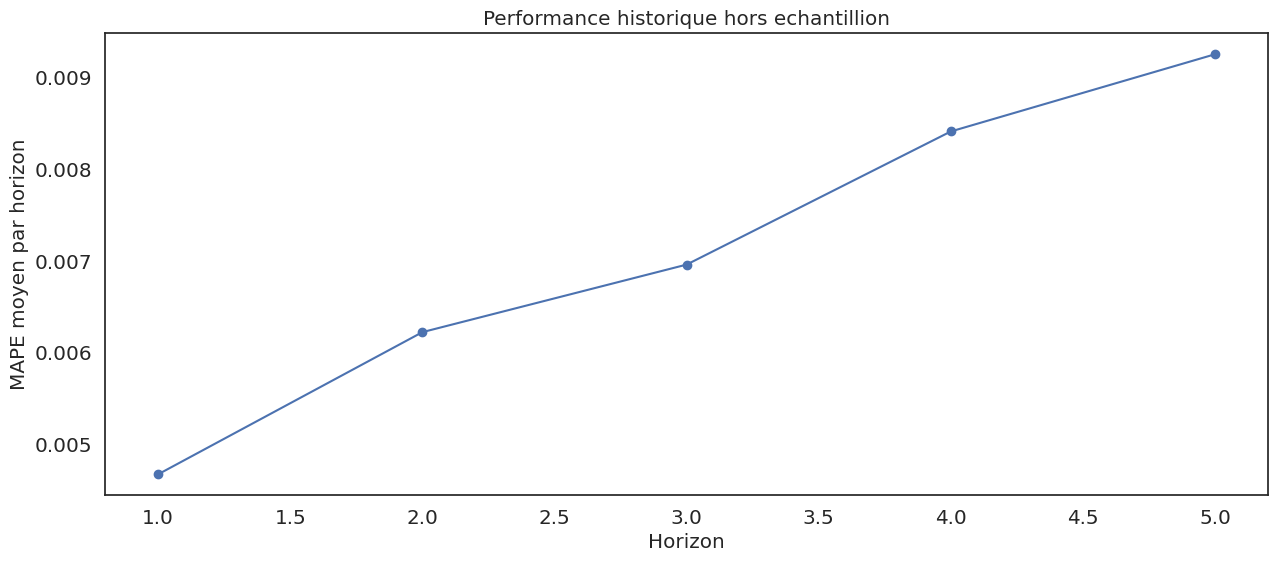

In [58]:
lf_eval.plot.plot_oos_horizon(score = 'MAPE',
                              xlabel = 'Horizon',
                              ylabel = 'MAPE moyen par horizon',
                              title ='Performance historique hors echantillion')

## Section 5: Generation des prediction

In [59]:
LF.predict?

Signature:
LF.predict(
    X: Optional[pandas.core.frame.DataFrame] = None,
    fh: Optional[sktime.forecasting.base._fh.ForecastingHorizon] = None,
    coverage: float = 0.9,
) -> Tuple[pandas.core.frame.DataFrame, pandas.core.frame.DataFrame]
Docstring:
Generate predictions (Average and confidence interval) using the fitted model.

Parameters:
    X : pd.DataFrame, optional
        Exogenous variables for forecasting. Default is None and takes the exogenous variables defined at instantiation.
    fh : ForecastingHorizon, optional
        Forecast horizon. Default is None and takes the horizon defined at instantiation.
    coverage : float, optional
        The coverage of the confidence interval. Default is 0.9.

Returns:
    Tuple[pd.DataFrame, pd.DataFrame]:
        A tuple containing the predictions and the confidence intervals.
File:      ~/Documents/Projects/forecast/forecast/forecast.py
Type:      method

In [60]:
# Reajuster sur tout l'echantillon pour 
LF.fit(on ='all')
# Predir
y_pred, y_pred_ints = LF.predict()

In [61]:
LF.plot.plot_prediction?

Signature:
LF.plot.plot_prediction(
    y_pred: pandas.core.series.Series,
    y_pred_ints: Optional[pandas.core.frame.DataFrame] = None,
    interval_label: str = 'prediction interval',
    labels: List[str] = ['y_train', 'y_pred'],
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    title: str = 'Prediction',
    ax: Optional[matplotlib.axes._axes.Axes] = None,
    figsize: Tuple[float, float] = (15, 6),
)
Docstring:
Plot the forecast predictions and the confidence intervals.

Parameters:
    y_pred : pd.Series
        The predicted values.
    y_pred_ints : pd.DataFrame, optional
        The DataFrame containing the prediction intervals.
    interval_label : str, optional
        Label for the prediction interval. Default is 'prediction interval'.
    labels : List[str], optional
        Labels for the plot. Default is ["y_train", "y_pred"].
    xlabel : str, optional
        Label for the x-axis.
    ylabel : str, optional
        Label for the y-axis.
    title

(<Figure size 1300x500 with 1 Axes>,
 <Axes: title={'center': 'Prediction du model ARIMA'}, ylabel='Billets et Monnaie en Circulation\nMilliards de MRU'>)

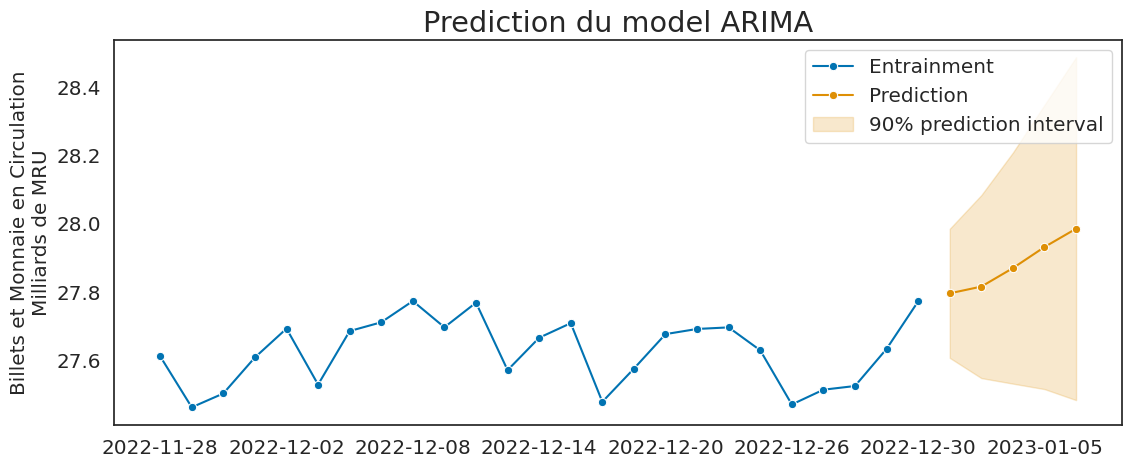

In [62]:
LF.plot.plot_prediction(y_pred, y_pred_ints, 
                        labels=['Entrainment', 'Prediction'], 
                        ylabel = 'Billets et Monnaie en Circulation\nMilliards de MRU',
                        title = 'Prediction du model ARIMA', 
                        figsize = (13,5)
                       )

### Section 6: Nouvelles donnees, Nouvelles predictions

### Lire les nouvelles donnees

In [63]:
# create a dataframe with the new data
newdata = pd.concat([data, 
                     pd.DataFrame(index=[y_pred.index[0]], columns =data.columns)
                    ])
newdata.loc[y_pred.index[0], 'BMC'] = y_pred.iloc[0]
newdata = newdata.ffill()
newdata.tail()

,BMC,jo_RIM,Pre_ramadan,Ramadan,Pre_Afitr,Post_AFitr,Pre_Akebir,Post_Akebir,Pre_ferie,Post_ferie,Pre_elec,Post_elec,Achat_or,Last_Day,First_Day
2022-12-27,27.512799,1,0,0,0,0,0,0,0,0,0,0,0.0,0,0
2022-12-28,27.523612,1,0,0,0,0,0,0,0,0,0,0,0.0,0,0
2022-12-29,27.632290,1,0,0,0,0,0,0,0,0,0,0,0.0,0,0
2022-12-30,27.771337,1,0,0,0,0,0,0,0,0,0,0,0.0,1,0
2023-01-02,27.794892,1,0,0,0,0,0,0,0,0,0,0,0.0,1,0


### Generer les predictions sans refiter le modele

In [64]:
LF.update?

Signature:
LF.update(
    newdata: pandas.core.frame.DataFrame,
    fh: Optional[sktime.forecasting.base._fh.ForecastingHorizon] = None,
    coverage: float = 0.9,
    refit: bool = False,
) -> Tuple[pandas.core.frame.DataFrame, pandas.core.frame.DataFrame]
Docstring:
Update cutoff value to forecast new dates.
Possibility to refit the model.

Parameters:
    newdata : pd.DataFrame
        The new data containing the same columns as the original data.
    fh : ForecastingHorizon, optional
        Forecast horizon. Default is None and takes the horizon defined at instantiation.
    coverage : float, optional
        The coverage of the confidence interval. Default is 0.9.
    refit : bool, optional
        If True, the model will be refitted on the new training data. Default is False.

Returns:
    Tuple[pd.DataFrame, pd.DataFrame]:
        A tuple containing the updated predictions and the updated confidence intervals.
File:      ~/Documents/Projects/forecast/forecast/forecast.py
Type: 

In [65]:
y_pred, y_pred_ints = LF.update(newdata = newdata)

In [66]:
y_pred

2023-01-03    27.794892
2023-01-04    27.814602
2023-01-05    27.868726
2023-01-06    27.930449
2023-01-09    27.984032
Freq: B, Name: BMC, dtype: float64

In [67]:
y_pred_ints

Coverage           
                  0.9           
                lower      upper
2023-01-03  27.605943  27.983842
2023-01-04  27.546793  28.082411
2023-01-05  27.530536  28.206916
2023-01-06  27.514560  28.346338
2023-01-09  27.482355  28.485710

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Prediction'}, ylabel='BMC'>)

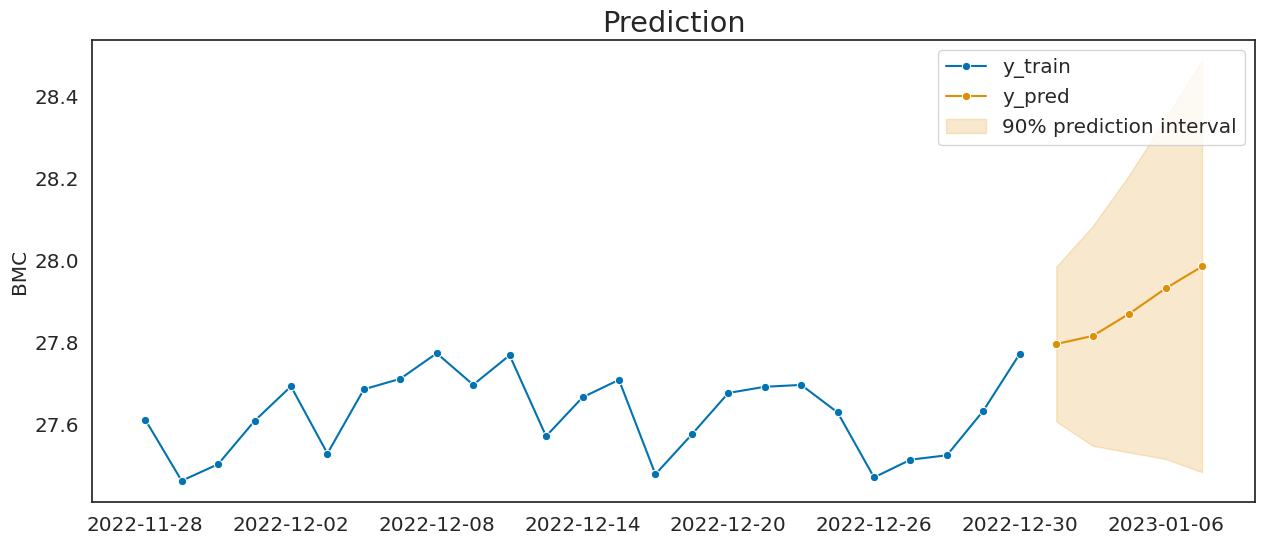

In [68]:
LF.plot.plot_prediction(y_pred, y_pred_ints)

### Generer les predictions en refittant le modele

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Prediction'}, ylabel='BMC'>)

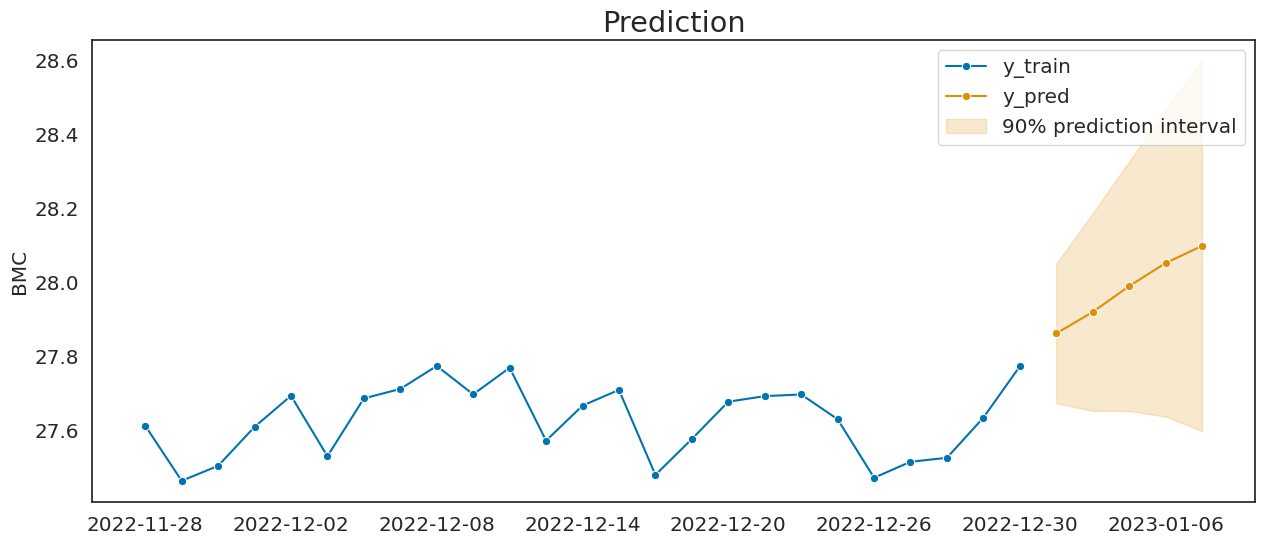

In [69]:
y_pred, y_pred_ints = LF.update(newdata = newdata,  refit=True)
LF.plot.plot_prediction(y_pred, y_pred_ints)